In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 
import os

import pickle
import random 

#sys.path.insert(0,"/home/mtissot/SpinUp/lib2")
#import prepare as p1
#import forecast as p2

import importlib
sys.path.insert(0,"/home/mtissot/SpinUp/jumper/lib")
from forecast import Predictions, Simulation, load_ts

#import jumper
#importlib.reload(jumper)

## What parameters we can change?

### Prepare
- path  : path of the simulation - string
- ye    : yearly average of the simulation - bool
- start : start for the training data int
- end   : end for the training data - int
- comp  : explained variance ratio - float or int

### Predictions:
- steps : Number of steps to forecast

# **LOAD & PREPARE**

In [2]:
import forecast
importlib.reload(forecast)
from forecast import Predictions, Simulation, load_ts

In [21]:
ye,start,end = True,25,125
ye = False
path ="/scratchu/mtissot/SIMUp6Y"

In [22]:
simu_zos    = Simulation(path=path,start=start,end=end,ye=ye,term="zos")    
print("zos loaded")
simu_so     = Simulation(path=path,start=start,end=end,ye=ye,term="so")   
print("so loaded")
simu_thetao = Simulation(path=path,start=start,end=end,ye=ye,term="thetao")   
print("thetao loaded")

#REMTTRE BIEN GET DATA APRES      return grid[:1] => return grid
simu_zos.prepare() 
print("\nzos prepared")
simu_so.prepare() 
print("so prepared")
simu_thetao.prepare() 
print("thetao prepared")


#LoadSimu : essayer avec des chunks plus gros et plus de jobs pour 3D 
#Prepare   : Cut spin Up - Remove Closed seas - Standardize - (old : Replace bathy nan values by the mean) - to float32

zos loaded
so loaded
thetao loaded

zos prepared
so prepared
thetao prepared


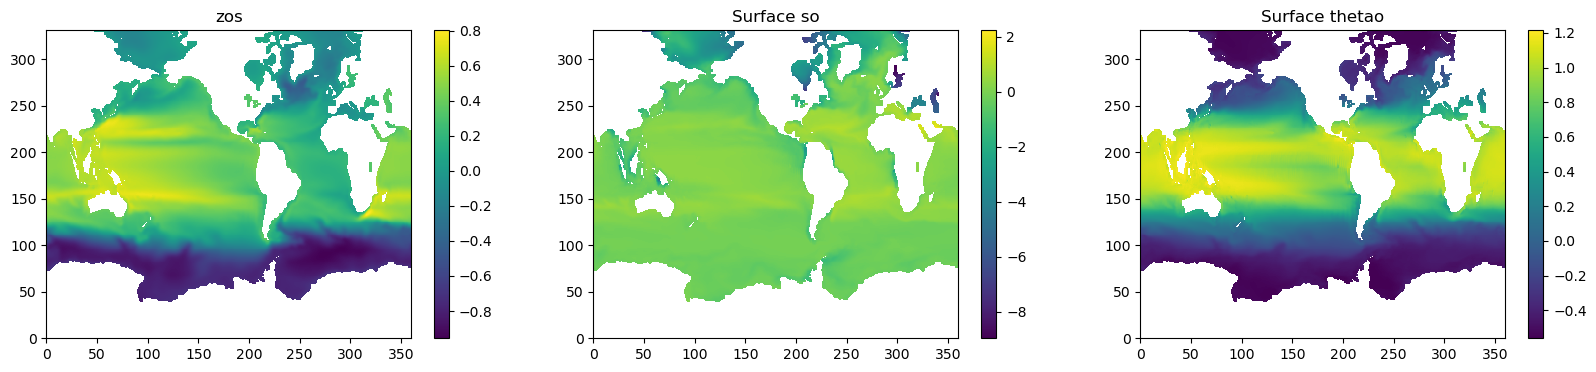

In [23]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

for i, simu in enumerate(simus):
    if simu.z_size is not None : 
        im = axes[i].pcolor(simu.simulation[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu.simulation[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])

if False:
    fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

    for i, simu in enumerate(simus):
        if simu.z_size is not None : 
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2,3)))
            axes[i].set_title(f"Average ssca - {names[i]}")
        else:
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2)))
            axes[i].set_title(f"Average ssca - {names[i]}")
    plt.colorbar(im, ax=axes[i])

# **TO TIME SERIES**

In [24]:
simu_zos.applyPCA()
print("PCA applied on zos")
simu_so.applyPCA()
print("PCA applied on so")
simu_thetao.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


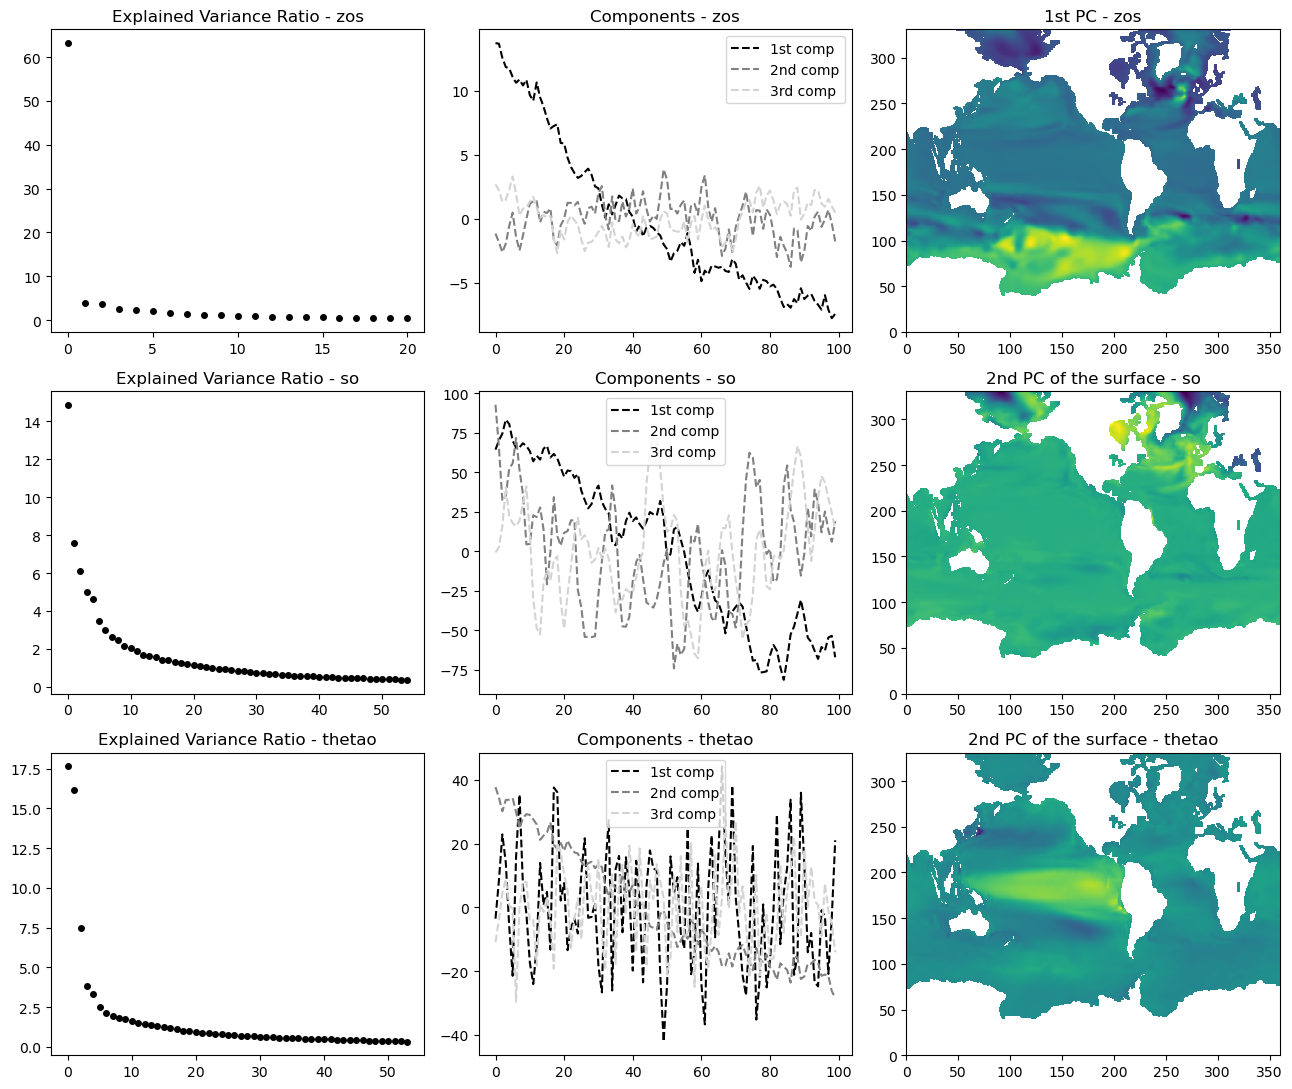

In [28]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]
#units = ["m","°C","g/kg"]
fig, axes = plt.subplots(3, 3, figsize=(13, 11))

for i, simu in enumerate(simus):
    axes[i,0].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[i,0].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[i,1].plot(simu.components[:, 0], linestyle = "dashed", color="black", label="1st comp")
    axes[i,1].plot(simu.components[:, 1], linestyle = "dashed", color="grey", label="2nd comp")
    axes[i,1].plot(simu.components[:, 2], linestyle = "dashed", color="lightgrey", label="3rd comp")
    axes[i,1].set_title(f"Components - {names[i]}")
    axes[i,1].legend()
    
    if simu.z_size is not None : 
        im = axes[i, 2].pcolor(simu.getPC(0)[0])
        #plt.colorbar(im, ax=axes[i, 2])#,label=units[i])
        axes[i,2].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[i,2].pcolor(simu.getPC(0))
        #plt.colorbar(im, ax=axes[i, 2])#,label=units[i])
        axes[i,2].set_title(f"1st PC - {names[i]}")
        
#fig.suptitle("PCA INFO")
plt.tight_layout()
plt.show()

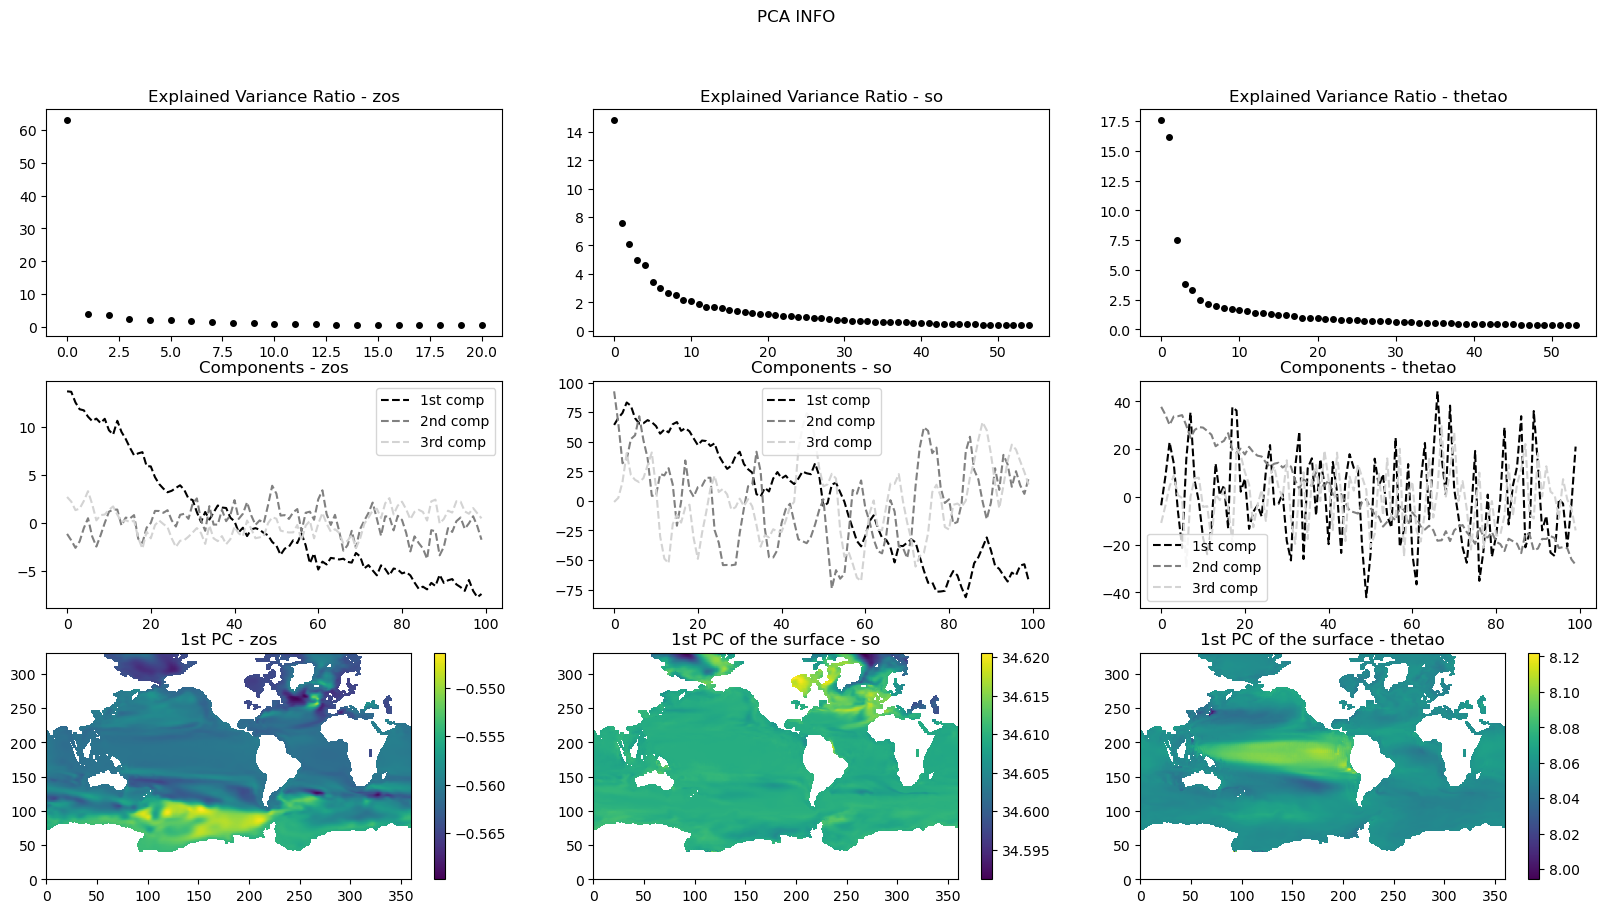

In [30]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]
#units = ["m","°C","g/kg"]
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], linestyle = "dashed", color="black", label="1st comp")
    axes[1, i].plot(simu.components[:, 1], linestyle = "dashed", color="grey", label="2nd comp")
    axes[1, i].plot(simu.components[:, 2], linestyle = "dashed", color="lightgrey", label="3rd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()
    
    if simu.z_size is not None : 
        im = axes[2, i].pcolor(simu.getPC(0)[0])
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.getPC(0))
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")
        
fig.suptitle("PCA INFO")
plt.show()

In [ ]:
n = len(simu_zos.pca.explained_variance_ratio_)
rec_zos,    rmseV_zos,    rmseM_zos    = simu_zos.rmseOfPCA(n)
print("RMSE compilated for zos")
n = len(simu_so.pca.explained_variance_ratio_)
rec_so,     rmseV_so,     rmseM_so     = simu_so.rmseOfPCA(n)
print("RMSE compilated for so")
n = len(simu_thetao.pca.explained_variance_ratio_)
rec_thetao, rmseV_thetao, rmseM_thetao = simu_thetao.rmseOfPCA(n)
print("RMSE compilated for thetao")

In [ ]:
values = [rmseV_zos,rmseV_so,rmseV_thetao]
maps   = [rmseM_zos,rmseM_so,rmseM_thetao]
names  = ["zos","so","thetao"]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(axes[0])):
    axes[0, i].plot(values[i],linestyle = "dashed",color="black", markersize =4)
    axes[0, i].set_title(f"Average rmse values - {names[i]}")

    if len(np.shape(maps[i]))==2: 
        im = axes[1, i].pcolor(maps[i])
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Mean rmse map - {names[i]}")
    else:
        im = axes[1, i].pcolor(np.nanmean(maps[i],axis=0))
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Average rmse map - {names[i]}")
        axes[0, i].plot(np.nanmean(values[i],axis=1),linewidth=1.5,color="red", markersize =4)
        
fig.suptitle("PCA EVALUATION - 1st COMP")
plt.show()

In [9]:
zos_dico = simu_zos.makeDico()
print("zos to dictionnary")
so_dico = simu_so.makeDico()
print("so to dictionnary")
thetao_dico = simu_thetao.makeDico()
print("thetao to dictionnary")

zos to dictionnary
so to dictionnary
thetao to dictionnary


In [10]:
f = "/data/mtissot/test_Forecast/simu_prepared/"
if not os.path.exists(f):
    os.makedirs(f)

with open(f + 'pca_so', 'wb') as file:
    pickle.dump(simu_so.pca, file)
with open(f + 'pca_thetao', 'wb') as file:
    pickle.dump(simu_thetao.pca, file)
with open(f + 'pca_zos', 'wb') as file:
    pickle.dump(simu_zos.pca, file)

np.savez(f + "so", **so_dico)
np.savez(f + "thetao", **thetao_dico)
np.savez(f + "zos", **zos_dico)


# **FORECAST**

In [31]:
f = "/data/mtissot/test_Forecast/simu_prepared/"

df_zos,infos_zos       = load_ts(f,"zos")
df_so,infos_so         = load_ts(f,"so")
df_thetao,infos_thetao = load_ts(f,"thetao")

random.seed(20)

ts_zos    = Predictions("zos",df_zos,infos_zos)  
ts_so     = Predictions("so",df_so,infos_so)  
ts_thetao = Predictions("thetao",df_thetao,infos_thetao)  

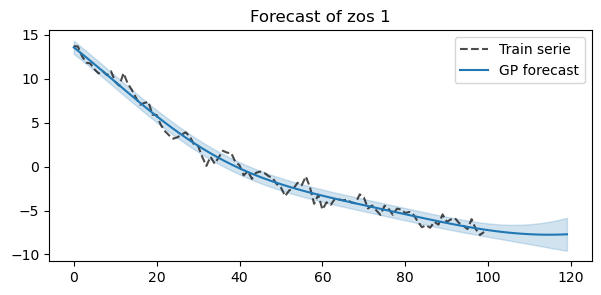

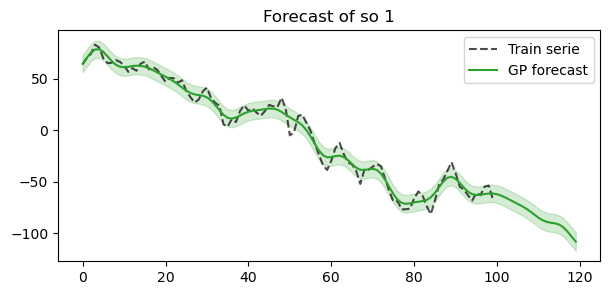

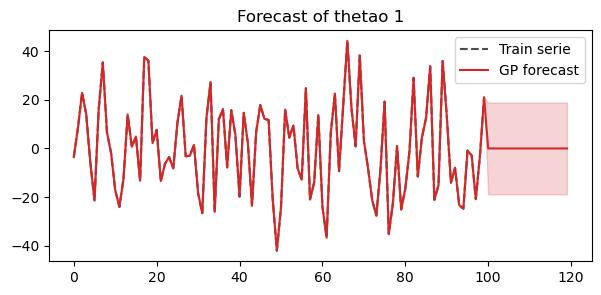

In [46]:
import random
random.seed(20)
comp,train_len,steps=1,len(ts_zos),20#,20#len(ts_zos),30

hat_zos,    std_zos,    metrics_zos    = ts_zos.forecast_ts(comp,train_len,steps)
hat_so,     std_so,     metrics_so     = ts_so.forecast_ts(comp,train_len,steps)
hat_thetao, std_thetao, metrics_thetao = ts_thetao.forecast_ts(comp,train_len,steps)

ts_zos.show(comp,hat_zos,std_zos,train_len)
ts_so.show(comp,hat_so,std_so,train_len,color="tab:green")
ts_thetao.show(comp,hat_thetao,std_thetao,train_len,color="tab:red")

In [47]:
hat_zos,    hat_std_zos,    metrics = ts_zos.Forecast(train_len,steps)
hat_so,     hat_std_so,     metrics = ts_so.Forecast(train_len,steps)
hat_thetao, hat_std_thetao, metrics = ts_thetao.Forecast(train_len,steps)

In [48]:
predictions_zos1     = ts_zos.reconstruct(hat_zos,1)
print("zos reconstructed with one comp")
predictions_so1      = ts_so.reconstruct(hat_so,1)
print("so reconstructed with one comp")
predictions_thetao1  = ts_thetao.reconstruct(hat_thetao,1)
print("thetao reconstructed with one comp")

zos reconstructed with one comp
so reconstructed with one comp
thetao reconstructed with one comp


In [49]:
predictions_zos2     = ts_zos.reconstruct(hat_zos,2)
print("zos reconstructed with two comp")
predictions_so2      = ts_so.reconstruct(hat_so,2)
print("so reconstructed with two comp")
predictions_thetao2  = ts_thetao.reconstruct(hat_thetao,2)
print("thetao reconstructed with two comp")

zos reconstructed with two comp
so reconstructed with two comp
thetao reconstructed with two comp


In [ ]:
n = np.shape(ts_zos.info["ts"])[1]
predictions_zos     = ts_zos.reconstruct(hat_zos,n)
print("zos reconstructed with all comp")
n = np.shape(ts_so.info["ts"])[1]
predictions_so      = ts_so.reconstruct(hat_so,n)
print("so reconstructed with all comp")
n = np.shape(ts_thetao.info["ts"])[1]
predictions_thetao  = ts_thetao.reconstruct(hat_thetao,n)
print("thetao reconstructed with all comp")

zos reconstructed with all comp


In [ ]:
maps  = [predictions_zos,predictions_so,predictions_thetao]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(maps), figsize=(20,4))

for i, simu in enumerate(maps):
    if len(np.shape(simu)) > 3 : 
        im = axes[i].pcolor(simu[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])


In [ ]:
#predictions_zos2    = np.load("/data/mtissot/simus_predicted/zos.npy")
#predictions_so2     = np.load("/data/mtissot/simus_predicted/so.npy")
#predictions_thetao2 = np.load("/data/mtissot/simus_predicted/thetao.npy")

# **EVALUATE ERROR**

In [ ]:
import importlib
import forecast
#importlib.reload(p1)
from forecast import Predictions, Simulation, load_ts

In [ ]:
start2,end2 = 25,125+30#start,end+steps
id_ = "106"
ye = False
path ="/scratchu/mtissot/SIMUp6Y"
simu_zos2 = Simulation(path=path,start=start2,end=end2,ye=ye,term="zos")    
print("zos loaded")
simu_so2  = Simulation(path=path,start=start2,end=end2,ye=ye,term="so")   
print("so loaded")
simu_thetao2 = Simulation(path=path,start=start2,end=end2,ye=ye,term="thetao")   
print("thetao loaded")

#REMTTRE BIEN GET DATA APRES      return grid[:1] => return grid
simu_zos2.prepare(stand=False) 
print("\nzos prepared")
simu_so2.prepare(stand=False) 
print("so prepared")
simu_thetao2.prepare(stand=False) 
print("thetao prepared")

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,4))

axes[0].plot(np.nanmean(predictions_zos1,axis=(1,2)),label="pred1")
axes[0].plot(np.nanmean(predictions_zos2,axis=(1,2)),label="pred2")
axes[0].plot(np.nanmean(predictions_zos,axis=(1,2)),label="predAll")
axes[0].plot(np.nanmean(simu_zos2.simulation[:],axis=(1,2)),label="ref")
axes[0].axvline(train_len, color="grey",linewidth=0.7)
axes[0].legend()

axes[1].plot(np.nanmean(predictions_so1,axis=(1,2,3)),label="pred1")
axes[1].plot(np.nanmean(predictions_so2,axis=(1,2,3)),label="pred2")
axes[1].plot(np.nanmean(predictions_so,axis=(1,2,3)),label="predAll")
axes[1].plot(np.nanmean(simu_so2.simulation[:],axis=(1,2,3)),label="ref")
axes[1].axvline(train_len, color="grey",linewidth=0.7)
axes[1].legend()

axes[2].plot(np.nanmean(predictions_thetao1,axis=(1,2,3)),label="pred1")
axes[2].plot(np.nanmean(predictions_thetao2,axis=(1,2,3)),label="pred2")
axes[2].plot(np.nanmean(predictions_thetao,axis=(1,2,3)),label="predAll")
axes[2].plot(np.nanmean(simu_thetao2.simulation[:],axis=(1,2,3)),label="ref")
axes[2].axvline(train_len, color="grey",linewidth=0.7)
axes[2].legend()

In [22]:
simu_zos2.applyPCA()
print("PCA applied on zos")
simu_so2.applyPCA()
print("PCA applied on so")
simu_thetao2.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


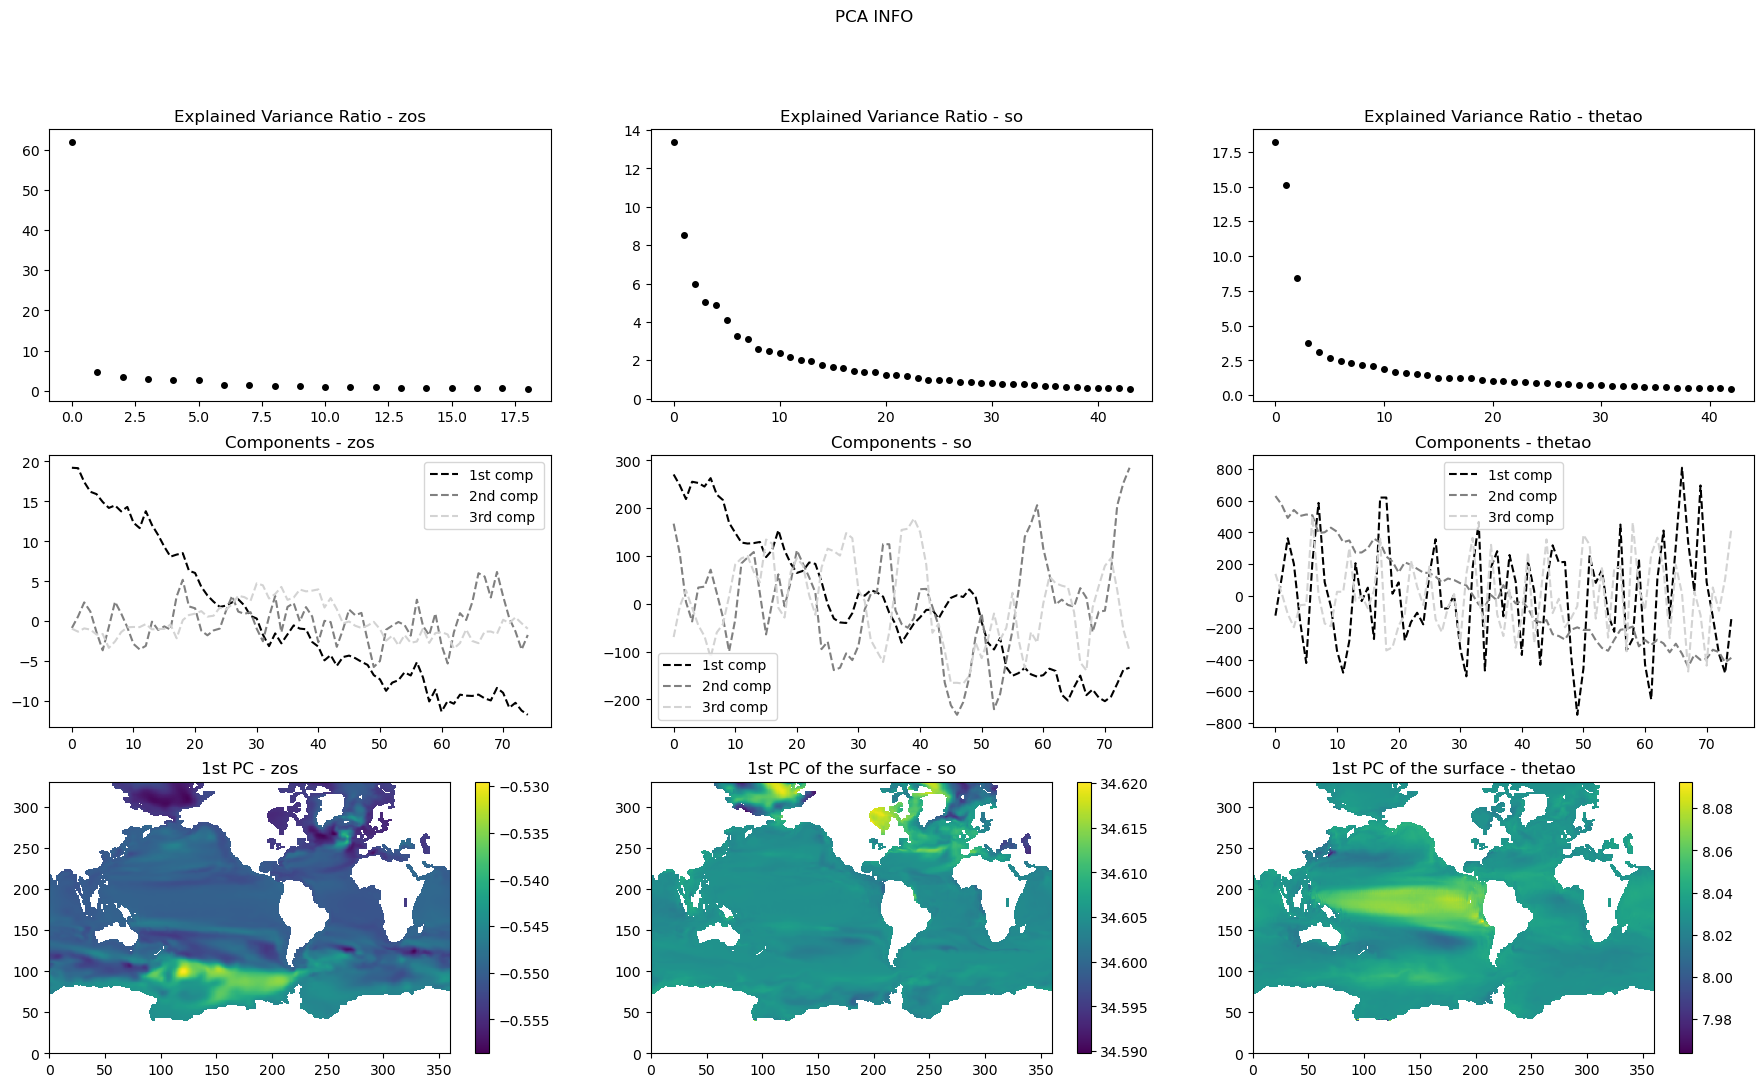

In [23]:
simus = [simu_zos2,simu_so2,simu_thetao2]
names = ["zos","so","thetao"]
#units = ["m","°C","g/kg"]
fig, axes = plt.subplots(3, 3, figsize=(22, 12))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], linestyle = "dashed", color="black", label="1st comp")
    axes[1, i].plot(simu.components[:, 1], linestyle = "dashed", color="grey", label="2nd comp")
    axes[1, i].plot(simu.components[:, 2], linestyle = "dashed", color="lightgrey", label="3rd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()
    
    if simu.z_size is not None : 
        im = axes[2, i].pcolor(simu.getPC(0)[0])
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.getPC(0))
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")
        
fig.suptitle("PCA INFO")
plt.show()

In [24]:
def getRmseV(s,p,steps):
    n = np.product(s.shape) - np.nansum(np.isnan(s.simulation[0]))
    c = np.sqrt(np.nansum(np.nansum((s.simulation[-steps:]-p[-steps:])**2,axis=-1),axis=-1)/n)
    return c# * 2 * s.desc["std"]

def rmseMap(s,p,window):
    t = s.len
    return np.sqrt(np.sum((s.simulation[-window:]-p[-window:])**2,axis=0)/t) #* 2 * s.desc["std"]

In [25]:
rmseV_zos2    = getRmseV(simu_zos2,predictions_zos,30)
rmseV_so2     = getRmseV(simu_so2,predictions_so,30)
rmseV_thetao2 = getRmseV(simu_thetao2,predictions_thetao,30)

rmseM_zos2    = rmseMap(simu_zos2,predictions_zos,3)
rmseM_so2     = rmseMap(simu_so2,predictions_so,3)
rmseM_thetao2 = rmseMap(simu_thetao2,predictions_thetao,3)

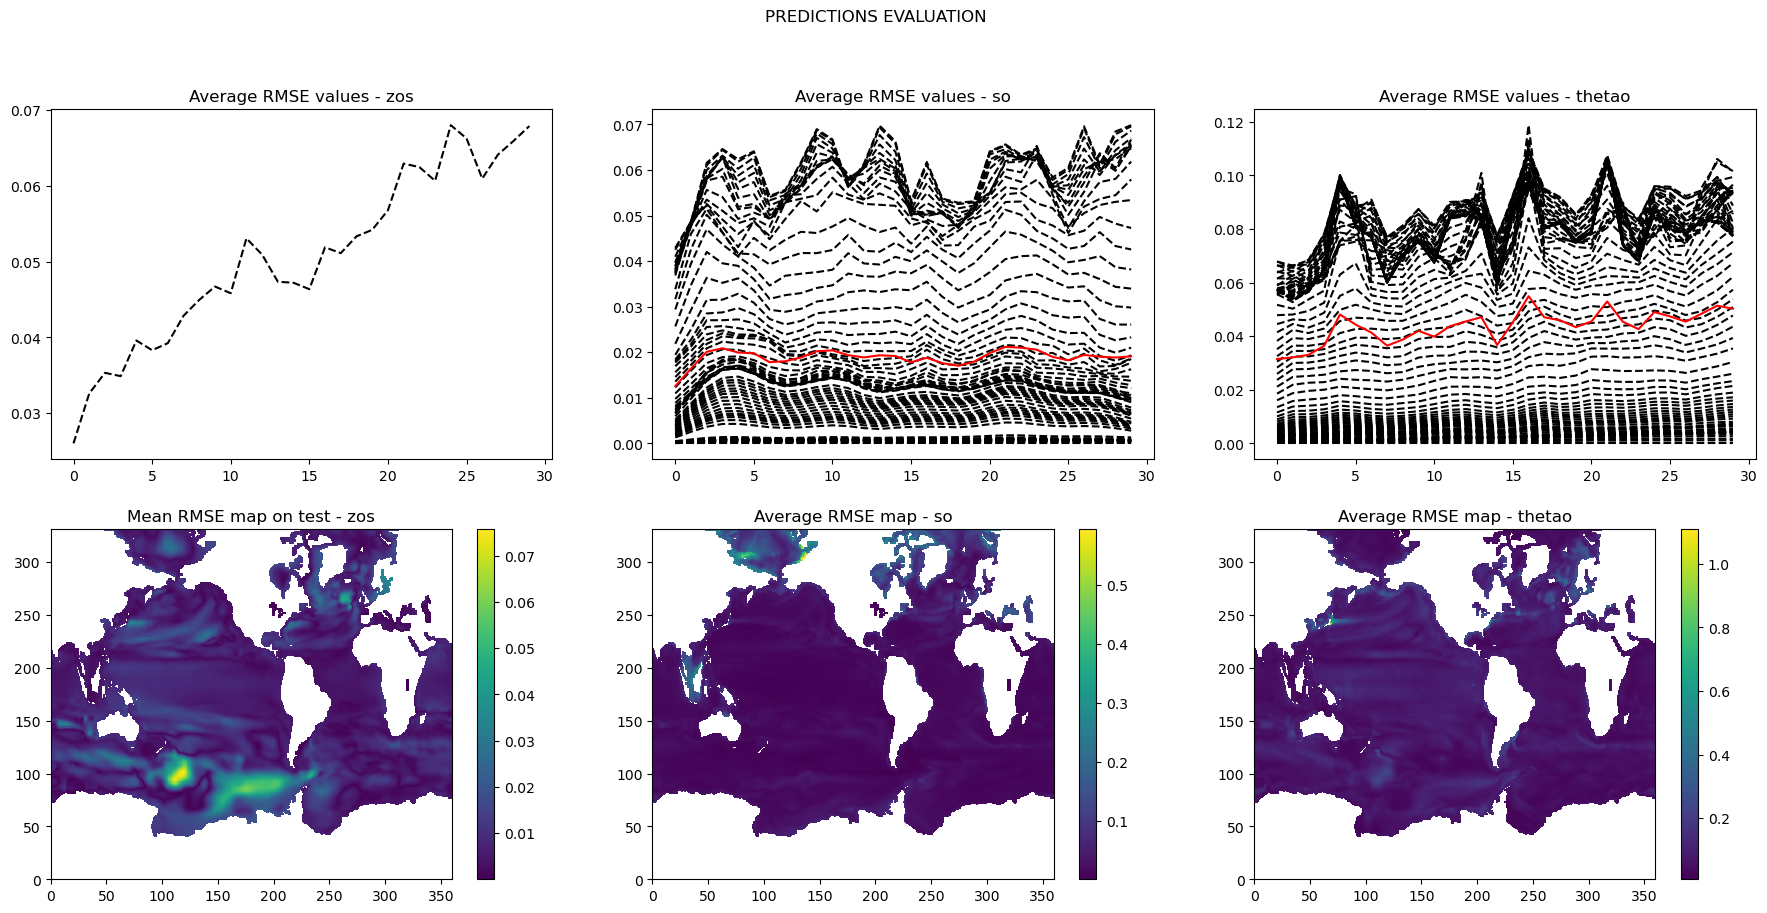

In [26]:
values = [rmseV_zos2, rmseV_so2, rmseV_thetao2]
maps   = [rmseM_zos2, rmseM_so2, rmseM_thetao2]
names  = ["zos", "so", "thetao"]

fig, axes = plt.subplots(2, 3, figsize=(22, 10))

for i in range(len(axes[0])):
    axes[0, i].plot(values[i], linestyle="dashed", color="black", markersize=4)
    #axes[0, i].axvline(train_len,color="black",alpha=0.5,linewidth=0.6,label='train limit')
    #axes[0, i].legend()
    axes[0, i].set_title(f"Average RMSE values - {names[i]}")

    if len(np.shape(maps[i])) > 2:
        axes[0, i].plot(np.nanmean(values[i], axis=1), linewidth=1.5, color="red", markersize=4)
        im = axes[1, i].pcolor(np.nanmean(maps[i], axis=0))
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Average RMSE map - {names[i]}")
    else:
        im = axes[1, i].pcolor(maps[i])
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Mean RMSE map on test - {names[i]}")

fig.suptitle("PREDICTIONS EVALUATION")
plt.show()

# **SAVE PREDICTIONS**

In [28]:
#np.save("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/simu_SU/pred_zos.npy", predictions_zos)
#np.save("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/simu_SU/pred_so.npy", predictions_so)
#np.save("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/simu_SU/pred_thetao.npy", predictions_thetao)